In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os 
import PIL
import glob
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from source.network import NNClassifier

from source.helpme import get_gesture_dataset, load_imgs_from_folder, show_image, calculate_pad, show_history

In [3]:
X, y = get_gesture_dataset(size=(64, 64), shuffle=True)

X.shape, y.shape

((2062, 1, 64, 64), (2062,))

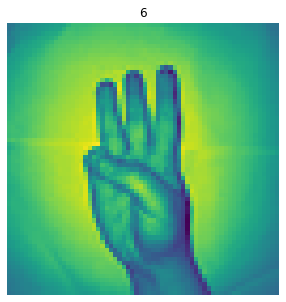

In [4]:
index = 573
show_image(X[index], title=y[index])

# Convolutional neural network

In [5]:
class Softmax_layer(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        e = torch.exp(x - x.max(1, True)[0] )
        summ = e.sum(1, True)[0]
        return e / summ
    
class Flatten(torch.nn.Module):
    def forward(self, x):
        N = x.shape[0]
        return x.view(N, -1)

In [6]:
calculate_pad(input_size = 64, kernel_size = 3, stride = 2, output_size = 32)

1

In [7]:
conv_net = torch.nn.Sequential(torch.nn.Conv2d(1, 8, 3, stride=2, padding=1),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm2d(8),
                               torch.nn.Dropout2d(0.01),
                               # 32x32x16
                               
                               torch.nn.Conv2d(8, 16, 3, stride=2, padding=1),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm2d(16),
                               torch.nn.Dropout2d(0.01),
                               # 16x16x32
                               
                               torch.nn.Conv2d(16, 32, 3, stride=2, padding=1),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm2d(32),
                               torch.nn.Dropout2d(0.01),
                               # 8x8x64
                               
                               torch.nn.Conv2d(32, 64, 3, stride=2, padding=1),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm2d(64),
                               torch.nn.Dropout2d(0.01),
                               # 4x4x64
                               
                               torch.nn.Conv2d(64, 128, 3, stride=2, padding=1),
                               torch.nn.ReLU(),
                               torch.nn.BatchNorm2d(128),
                               torch.nn.Dropout2d(0.01),
                               # 2x2x128
                               
                               Flatten(),
                               torch.nn.Linear(512, 10),
                               Softmax_layer())

In [8]:
model = NNClassifier(conv_net, lr=5e-3, device='cuda')

In [9]:
train_size = 1400
valid_size = 250
test_size = len(X) - train_size - valid_size
print('train size =', train_size)
print('valid size =', valid_size)
print('test size =', test_size)

X_train = X[ : train_size]
y_train = y[ : train_size]

X_valid = X[train_size : train_size+valid_size]
y_valid = y[train_size : train_size+valid_size]

X_test = X[train_size+valid_size : ]
y_test = y[train_size+valid_size : ]

train size = 1400
valid size = 250
test size = 412


In [10]:
model.fit(X_train, y_train, epochs=400, batch_size=6000, 
          valid_data=(X_valid, y_valid), log_every_epoch=1)

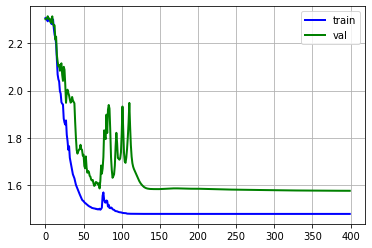

In [11]:
show_history(model.train_history, model.valid_history, width=2, fontsize=10)

In [12]:
model.evaluate_score(X_test, y_test)

0.8567961165048543

# Testing on real data

Перед тем как перейти к тестированию на реальных данных, надо положить картинки в любом формате в папку source/real_data. Все что там находится можно удалить.

In [13]:
imgs = load_imgs_from_folder(os.path.join('source', 'real_data'), size=(64,64))

In [14]:
imgs.shape

(30, 1, 64, 64)

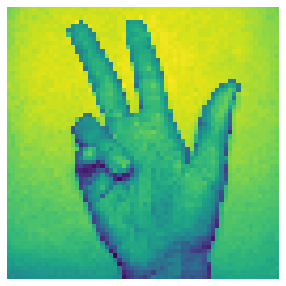

In [15]:
show_image(imgs[12])

In [16]:
model.predict(imgs)

array([7, 4, 5, 6, 5, 6, 8, 8, 9, 4, 4, 4, 9, 4, 5, 6, 4, 8, 9, 5, 4, 6,
       3, 4, 5, 6, 4, 8, 9, 4], dtype=int64)

In [24]:
torch.save(conv_net.state_dict(), './my_network.pt')